In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, get_conv_weights
from my_utils.vis import *

%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{2}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:2 now!


In [3]:
batch_size = 512
fig_resize = 64
# mean, std = torch.tensor(0.2036), torch.tensor(0.4027)  # polygons_unfilled_32_2
mean, std = torch.tensor(0.1094), torch.tensor(0.3660)  # polygons_unfilled_64_3
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
val_model = models.simple_Conv(kernel_size=7, depths=(1, 2, 1), dims=(4, 8, 16))
val_model.to(device)

load_path = '/home/wangyh/01-Projects/03-my/finalruns/simple_conv/KS_7_LR_1.5e-04_WD_5.0e-03_CT_30/2022_04_30_16_30_59/98_simple_conv_2022_04_30_16_56_51.pt'
checkpoint = torch.load(load_path)
val_model.load_state_dict(checkpoint["model_paras"])

FileNotFoundError: [Errno 2] No such file or directory: '/home/wangyh/01-Projects/03-my/finalruns/simple_conv/KS_7_LR_1.5e-04_WD_5.0e-03_CT_30/2022_04_30_16_30_59/98_simple_conv_2022_04_30_16_56_51.pt'

In [6]:
val_model.eval()
test_acc = check_accuracy(val_model, test_loader)
print(f'Test accuracy is : {100. * test_acc:.2f}%')

Test accuracy is : 98.84%	Infer time: 1.8798754215240479


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [283]:
img, label = test_data[1000]
img = img.unsqueeze(dim=0).to(device, dtype=torch.float32)
# label = label.to(device, dtype=torch.int64)
# vis = img.permute(0, 2, 3, 1)  # (1, C, H, W) -> (1, H, W, C)
scores, mid_outputs = vis_model(img)

In [37]:
imgs, labels = next(iter(test_loader))
null_imgs = imgs[:6].to(device)
labels = labels[:6]


In [48]:
null_imgs

tensor([[[[-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          ...,
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989]]],


        [[[-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          ...,
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989]]],


        [[[-0.2989, -0.2989, -0.2989,  ..., -0.2989, -0.2989, -0.2989],
          [-0.2989, -0.298

In [ ]:
print('min: ', torch.dist(*mid_outputs[2][0, [9, 29]]))
print('max: ', torch.dist(*mid_outputs[2][0, [4, 13]]))
print('abnormal: ', torch.dist(*mid_outputs[2][0, [4, 8]]))
torch.dist(*mid_outputs[2][0, [24, 31]])

In [9]:
from SimCam import SimCam

In [46]:
sim_maps = SimCam(vis_model, null_imgs, layer=-1, softmax=False, normalize=True)

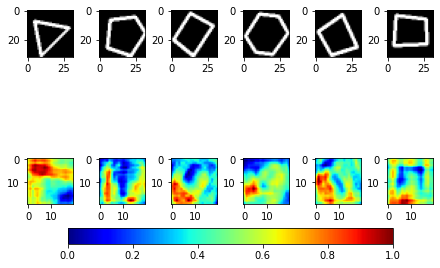

In [47]:
from SimCam.vis import vis_cam

vis_cam(null_imgs, None, None, sim_maps)

In [209]:
weight = vis_model.head.weight.detach().cpu()
weight.shape

torch.Size([4, 16])

In [210]:
w = weight[0:1]
w

tensor([[-0.5346,  0.7557, -0.6897,  0.4790,  0.5357,  0.2938,  0.9247, -0.5013,
          0.7191, -0.8894, -0.5299, -0.4886, -0.5137, -0.9334,  0.8474, -0.4114]])

In [176]:
sim_w = torch.concat(tensors=(sims[None, :], w), dim=0)
sim_w

tensor([[5.1650e-06, 6.7893e-06, 5.4062e-09, 7.9646e-05, 2.2127e-02, 6.6865e-01,
         3.6390e-04, 8.0715e-09, 3.0876e-01, 1.5606e-09, 6.6582e-09, 5.1414e-08,
         2.6504e-09, 2.5365e-06, 2.9193e-07, 6.6663e-09],
        [3.1396e-02, 1.1409e-01, 2.6886e-02, 8.6512e-02, 9.1558e-02, 7.1889e-02,
         1.3510e-01, 3.2459e-02, 1.0998e-01, 2.2018e-02, 3.1544e-02, 3.2873e-02,
         3.2059e-02, 2.1071e-02, 1.2504e-01, 3.5513e-02]])

<AxesSubplot:>

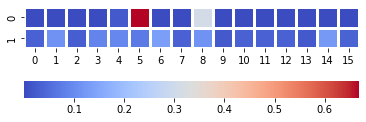

In [177]:
from seaborn import heatmap

heatmap(data=sim_w, square=True,
        linewidths=3, linecolor='white',
        cmap='coolwarm', cbar_kws={"orientation": "horizontal"})

In [257]:
sim_cam = (sims[:, None, None] * mid_outputs[-1]).sum(dim=0)
sim_cam

tensor([[ 0.5212,  0.6033,  0.7327,  0.7345,  0.7439,  0.4970,  0.3603,  0.2127,
          0.2403,  0.0558,  0.0402, -0.2287, -0.2714, -0.3068, -0.1189,  0.0280,
         -0.0709, -0.2158, -0.1585, -0.4623],
        [ 0.3781,  0.3598,  0.4248,  0.3646,  0.2640,  0.1211,  0.1787,  0.1112,
          0.0611,  0.0142,  0.0477, -0.2406, -0.3515, -0.2424,  0.1977,  0.4071,
          0.2152, -0.1993, -0.1913, -0.4030],
        [ 0.5066,  0.4462,  0.3581,  0.2838,  0.1847,  0.2614,  0.1596, -0.0157,
         -0.0615, -0.1154, -0.2098, -0.4504, -0.3971, -0.1685,  0.2932,  0.4686,
          0.2837, -0.1979, -0.0103, -0.3295],
        [ 0.5729,  0.3591,  0.3513,  0.2451,  0.3367,  0.1779,  0.0767, -0.1062,
         -0.0572, -0.2227, -0.2947, -0.2605, -0.1722,  0.0337,  0.3141,  0.4632,
          0.3748,  0.0571,  0.1149, -0.1836],
        [ 0.3171,  0.1709,  0.3086,  0.2835,  0.1636,  0.0540, -0.0848, -0.1956,
         -0.3323, -0.3045, -0.2382, -0.1601, -0.1408, -0.2257,  0.0017,  0.3424,
      

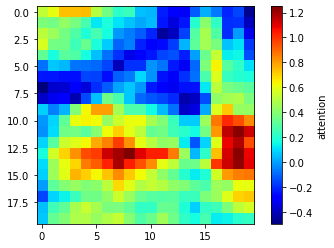

In [260]:
plt.imshow(sim_cam, cmap='jet')
plt.colorbar(label="attention")

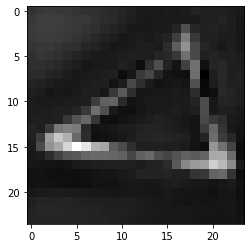

In [220]:
masked_img = sim_cam * null_img
plt.imshow(masked_img, cmap='gray')

In [30]:
img_tensor = img.squeeze().cpu()
sims = torch.zeros(mid_outputs[2][0].size(0))
for i, act in enumerate(mid_outputs[2][0]):
    sims[i] = (act * img_tensor).sum() / \
              torch.sqrt(torch.sum(act**2) * torch.sum(img_tensor**2))
print(sims)
print(torch.softmax(sims, dim=0))

tensor([ 0.3032,  0.4975,  0.4813,  0.4230,  0.3861, -0.3819, -0.5882,  0.1313,
        -0.5427, -0.0191,  0.5486,  0.3622,  0.1275,  0.5252, -0.3364, -0.1928])
tensor([0.0709, 0.0862, 0.0848, 0.0800, 0.0771, 0.0358, 0.0291, 0.0597, 0.0304,
        0.0514, 0.0907, 0.0753, 0.0595, 0.0886, 0.0374, 0.0432])


In [5]:
from sklearn.decomposition import PCA

In [9]:
test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, batch_size=len(test_data))
imgs, labels = next(iter(test_loader))
input_imgs = imgs.reshape(len(test_data), -1)
input_imgs.shape

torch.Size([8000, 1024])

In [10]:
labels.shape

torch.Size([8000])

In [12]:
x2 = PCA(2).fit_transform(input_imgs)
x2.shape

(8000, 2)

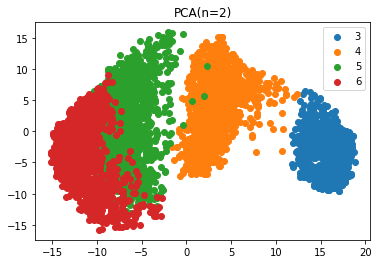

In [19]:
plt.figure()
for i in range(4):
    plt.scatter(x2[labels==i, 0], x2[labels==i, 1], label = f'{i+3}')
plt.legend()
plt.title("PCA(n=2)")
plt.show()

In [16]:
x3 = PCA(3).fit_transform(input_imgs)
x3.shape

(8000, 3)

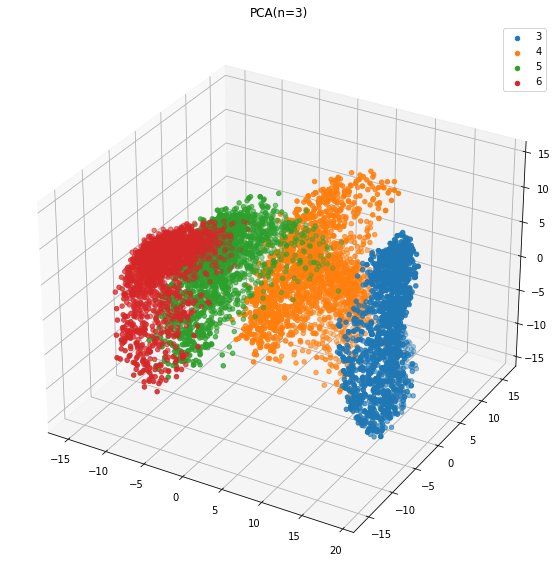

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    ax.scatter(x3[labels==i, 0], x3[labels==i, 1], x3[labels==i, 2], label = f'{i+3}')
plt.legend(loc='best')
plt.title("PCA(n=3)")
plt.show()

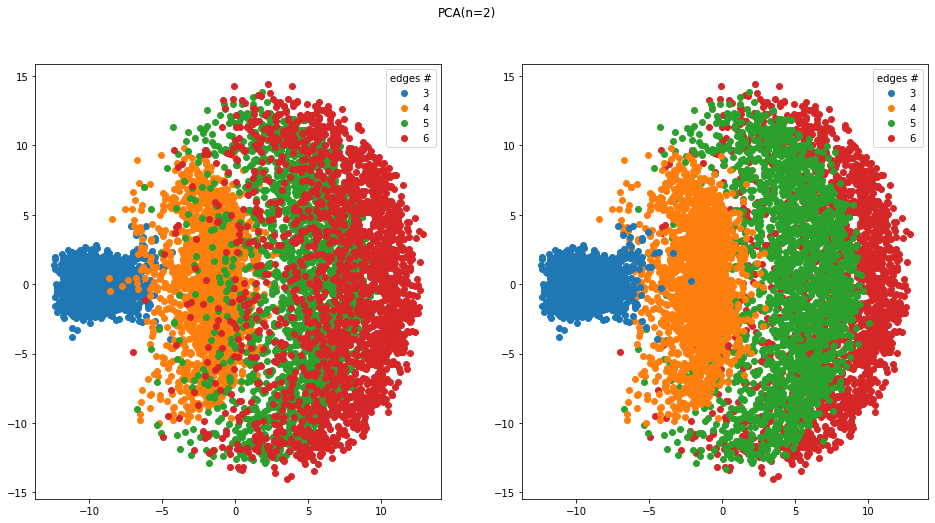

In [38]:
Vis_pca(dim=2,
        dataset_dir='/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3',
        dataset_type="val")

In [243]:
from torch import nn

x = torch.tensor([1, -2, 3])
m = x < 0
w = torch.softmax(x.__abs__().float(), dim=0)
w[m] *= -1
w

tensor([ 0.0900, -0.2447,  0.6652])

In [42]:
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'

vis_data = data.MyDataset(os.path.join(Dataset_DIR, 'vis'), transform=transforms.ToTensor())
vis_loader = DataLoader(vis_data, batch_size=8)

In [5]:
imgs, labels = next(iter(vis_loader))
print(imgs.shape)
print(labels)

torch.Size([8, 1, 64, 64])
tensor([0, 0, 1, 1, 2, 2, 3, 3])


In [6]:
cam_model = models.simple_Conv(kernel_size=9, depths=(1, 2, 1), dims=(2, 4, 8), act='relu', norm='LN', use_GSP=False)
if use_cuda:
    cam_model.to(device)
print(cam_model)

simple_Conv(
  (act_layer): ReLU()
  (stages): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 2, kernel_size=(9, 9), stride=(1, 1), padding=same, bias=False)
      (LN-2): LayerNorm()
    )
    (1): Sequential(
      (0): Conv2d(2, 4, kernel_size=(9, 9), stride=(1, 1), padding=same, bias=False)
      (LN-4): LayerNorm()
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 4, kernel_size=(9, 9), stride=(1, 1), padding=same, bias=False)
        (LN-4): LayerNorm()
      )
    )
    (3): Sequential(
      (0): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=same, bias=False)
      (LN-8): LayerNorm()
    )
  )
  (GAP): GAP(
    (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (head): Linear(in_features=8, out_features=4, bias=True)
  (loss_func): CrossEntropyLoss()
)


In [7]:
ckpt_path = '/home/wangyh/01-Projects/03-my/test_runs/simple_conv/KS_9_ACT_relu_Norm_LN/2022_05_31_22_51_30/checkpoints/best.pth'
checkpoint = torch.load(ckpt_path)
# checkpoint.keys()

In [8]:
checkpoint['best_val_acc']

tensor(0.9758, device='cuda:0')

In [9]:
new_state_dict = {k.replace('module.',''):v for k,v in checkpoint['model'].items()}
cam_model.load_state_dict(new_state_dict)

<All keys matched successfully>

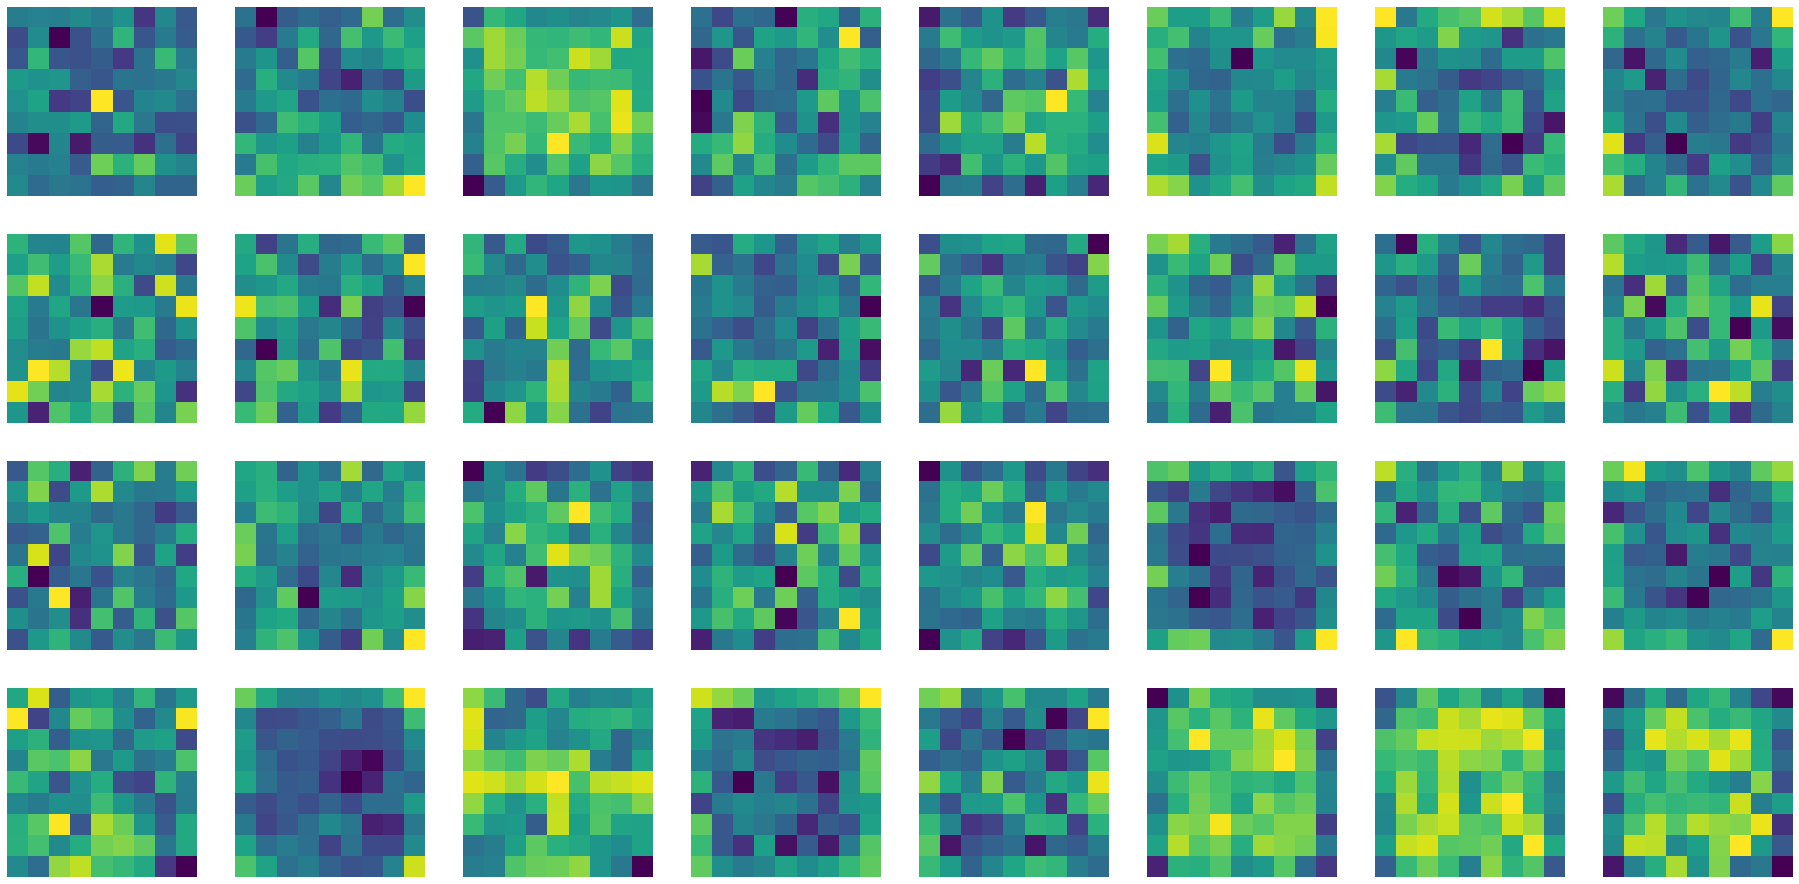

In [19]:
fig_array = vis_4D(data=cam_model.stages[3][0].weight.detach().cpu().numpy().transpose((1,0,2,3)),
                   figsize_factor=3,
                   cmap='viridis',
                   return_fig_array=True)

In [41]:
weights = get_conv_weights(cam_model)
weights[0].shape

(1, 2, 9, 9)

In [39]:
img, label = vis_data[0]
img = img.unsqueeze(dim=0).to(device, dtype=torch.float32)
label = torch.Tensor([label]).unsqueeze(dim=0).to(device)

In [40]:
from my_utils.utils import Hook

act_hook = Hook()
cam_model.act_layer.register_forward_hook(act_hook)

In [41]:
from torch.cuda.amp import autocast

# act_hook.__init__()
cam_model.eval()
with autocast():
    loss, preds = cam_model((imgs.to(device), labels.to(device)))
print(preds)

tensor([0, 0, 1, 1, 1, 1, 3, 3], device='cuda:2')


In [33]:
for idx, f in enumerate(act_hook.out_features):
    print(idx, f.shape)

0 torch.Size([8, 2, 64, 64])
1 torch.Size([8, 4, 64, 64])
2 torch.Size([8, 4, 64, 64])
3 torch.Size([8, 8, 64, 64])


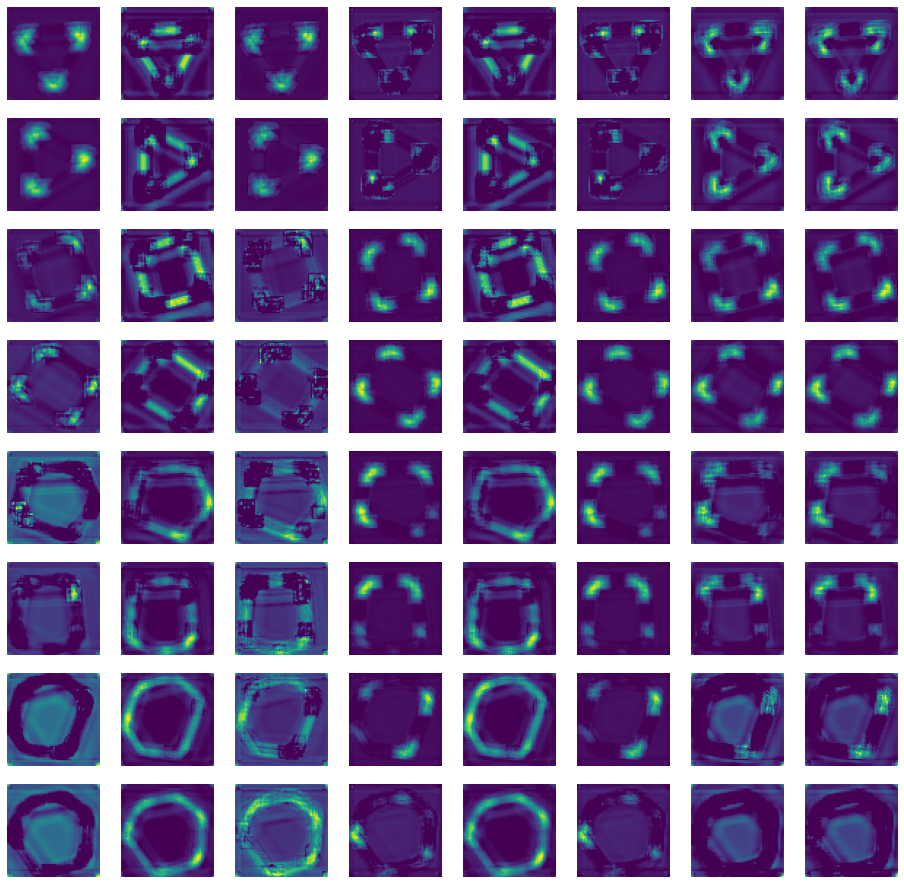

In [34]:
vis_4D(data=act_hook.out_features[3].detach().cpu().numpy(),
       figsize_factor=2,
       cmap='viridis')

AttributeError: __exit__

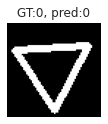

In [40]:
Vis_cam(vis_loader, cam_model, target_layers=[cam_model.stages[3][0]], img_num=8)

In [167]:
from SimCam.grad_cam import MyGradCAM

my_gradcam = MyGradCAM(cam_model, target_layer=cam_model.stages[3][0], use_cuda=True)

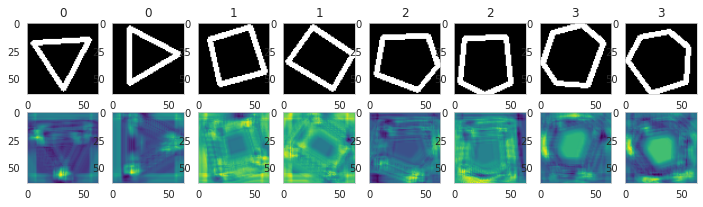

In [168]:
plt.figure(figsize=(12, 3))
for i in range(8):
    null_img, label = vis_data[i]
    plt.subplot(2, 8, i + 1)
    plt.imshow(null_img[0], cmap='gray')
    plt.grid()
    plt.title(label)

    plt.subplot(2, 8, i + 9)
    plt.imshow(my_gradcam(vis_data[i][0].unsqueeze(dim=0), label), cmap='viridis')
    plt.grid()
plt.show()

In [72]:
cam_maps[0] == cam_maps[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

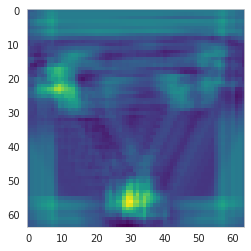

In [55]:
plt.imshow(cam_maps[0][0], cmap='viridis')
plt.grid(False)
plt.show()

In [206]:
from SimCam.sim_cam import MySimCAM

my_simcam = MySimCAM(cam_model, target_layer=cam_model.stages[3][0], use_cuda=True)

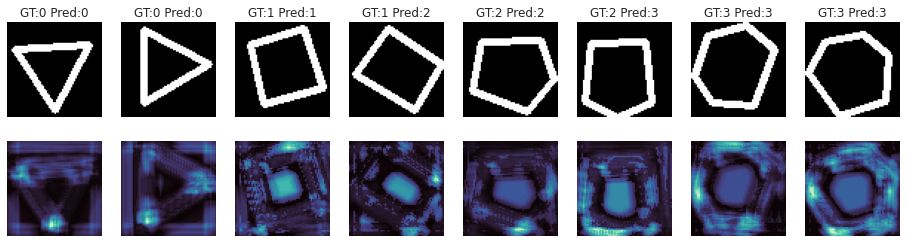

In [213]:
plt.figure(figsize=(16, 4))
for i in range(8):
    null_img, label = vis_data[i]
    pred_cls, cam_map = my_simcam(vis_data[i][0].unsqueeze(dim=0), target_cls=label)
    plt.subplot(2, 8, i + 1)
    plt.imshow(null_img[0], cmap='gray')
    plt.grid()
    plt.axis('off')
    plt.title(f'GT:{label} Pred:{pred_cls}')

    plt.subplot(2, 8, i + 9)
    plt.imshow(cam_map, cmap='mako')
    plt.grid()
    plt.axis('off')
plt.show()

In [88]:
sim_cam_map[0] == sim_cam_map[1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [80]:
torch.var_mean(my_simcam.grad_hook.out_features[0][0])

(tensor(7.7855e-08, device='cuda:2'), tensor(5.8360e-05, device='cuda:2'))

In [81]:
my_simcam.input_tensor.shape

torch.Size([1, 1, 64, 64])

In [139]:
scores = torch.randn((3, 4))
target_cls = torch.randint(4, size=(3,))
scores, target_cls

(tensor([[-0.5468,  1.3187, -0.1096, -0.2820],
         [ 0.3085, -0.8957, -0.1708,  0.5094],
         [-3.0820, -0.1768,  0.5041, -0.2479]]),
 tensor([2, 1, 3]))

In [141]:
torch.gather(scores,dim=1, index=target_cls[:, None])

tensor([[-0.1096],
        [-0.8957],
        [-0.2479]])

In [125]:
scores[idxs]

IndexError: index 3 is out of bounds for dimension 0 with size 3